# Analysis with simulated data

- data in the "caclean-masterdir” onedrive folder:
    - 4D TIFFs (the name starts with confocalSNR…,)
    - can be opened straight with Fiji/ImageJ (setting B & C to scale from 1.0 to 1.8 and choosing the jet lookup table)
    - contain FCa normalised as F/F_0
    - time steps are 1ms 
    - x,y,z voxel size is 0.215 um or very similar

In [1]:
import numpy as np
import napari

#### Load data

In [2]:
import os
import tifffile

Load noisy data

---> don't need this for the moment

In [3]:
# data_path = r'C:\Users\dotti\OneDrive - Universitaet Bern\caclean-masterdir'
# filename_snr100 = 'confocalSNR100.tiff'
# filemane_snr20 = 'confocalSNR20.tiff'


# # load tiff volume
# data_snr100 = tifffile.imread(os.path.join(data_path, filename_snr100)) # 151(t) x 22(z) x 80(y) x 54(x)
# data_snr20 = tifffile.imread(os.path.join(data_path, filemane_snr20)) # 151(t) x 22(z) x 80(y) x 54(x)
# # need to pad data

In [8]:
# data_snr100.shape, data_snr20.shape

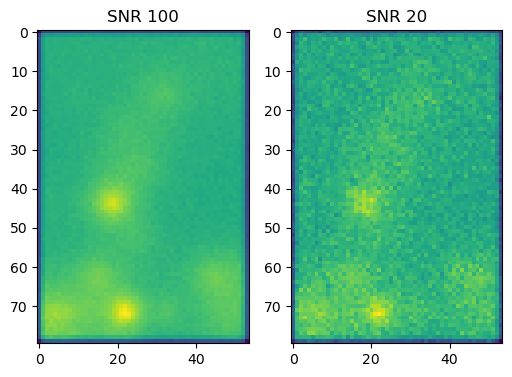

In [4]:
# import matplotlib.pyplot as plt

# fig_t = 80
# fig_z = 11

# # plot sample frame from data_snr100 and data_snr20
# plt.figure(figsize=(6,6))
# plt.subplot(1,2,1)
# plt.imshow(data_snr100[fig_t,fig_z,:,:])
# plt.title('SNR 100')
# plt.subplot(1,2,2)
# plt.imshow(data_snr20[fig_t,fig_z,:,:])
# plt.title('SNR 20')
# plt.show()

In [40]:
# # open snr_100 using napari
# viewer = napari.view_image(data_snr100)

Load clean data

---> need to find/generate corresponding noisy data

In [11]:
clean_data_path = r'C:\Users\dotti\OneDrive - Universitaet Bern\caclean-masterdir\CardiacCalcium_TestCaCLEAN\simulatedMicroscopy_outputs'
filename_clean = 'FCa_1umSpacing_NoMito_interp53_151timesteps.npz'
data_clean = np.load(os.path.join(clean_data_path, filename_clean))

In [12]:
data_clean.files

['nn_interp']

In [13]:
data_clean = data_clean['nn_interp'] # 151(t) x 213(z) x 205(y) x 317(x)

In [ ]:
data_clean.shape

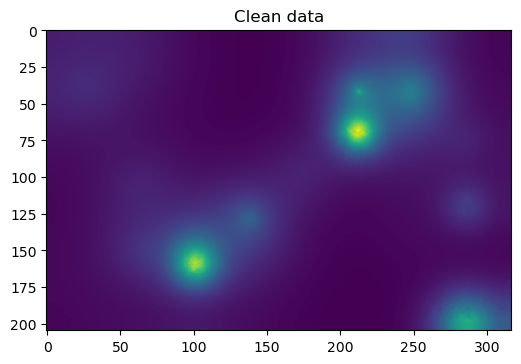

In [14]:
import matplotlib.pyplot as plt

fig_t = 75
fig_z = 106

# plot sample frame from data_clean
plt.figure(figsize=(6,6))
plt.imshow(data_clean[fig_t,fig_z,:,:])
plt.title('Clean data')
plt.show()

In [15]:
# visualize clean data with Napari
viewer = napari.view_image(data_clean)

Load Matlab files

---> don't need this for the moment

In [41]:
# from scipy.io import loadmat

# matlab_data_path = r'C:\Users\dotti\OneDrive - Universitaet Bern\caclean-masterdir\CardiacCalcium_TestCaCLEAN\simulatedMicroscopy_outputs'
# # load matlab file
# mat = loadmat(os.path.join(matlab_data_path,
#                           'simulatedMicroscopyResults_interp53_SNR20_1umSpacing_NoMito_54x80x151.mat'))
# #this is the same data as data_snr20 !!!

In [42]:
# mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'MultiMask', 'MultiRyrClusterCenters', 'RyrTolerances', 'MultiBgr', 'MultiIdenoised', 'xyt_dim'])

In [ ]:
# data_denoised = mat['MultiIdenoised']
# data_bgr = mat['MultiBgr']

In [50]:
# clean_mat = data_denoised - data_bgr
# clean_mat = np.transpose(clean_mat, (3,0,2,1))

In [47]:
data_denoised.shape, data_bgr.shape, clean_mat.shape

((22, 54, 80, 151), (22, 54, 80, 151), (22, 54, 80, 151))

In [53]:
viewer = napari.Viewer()
viewer.add_image(data_snr20,
                 name='data snr20')
viewer.add_image(clean_mat,
                 name='clean_mat')

<Image layer 'clean_mat' at 0x1b0046fd490>

### Create annotations from noise-free simulated data

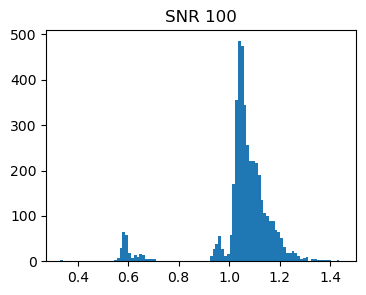

In [6]:
# plot snr_100 histogram
plt.figure(figsize=(4,3))
plt.hist(data_snr100[fig_t,fig_z,:,:].flatten(), bins=100)
plt.title('SNR 100')
plt.show()

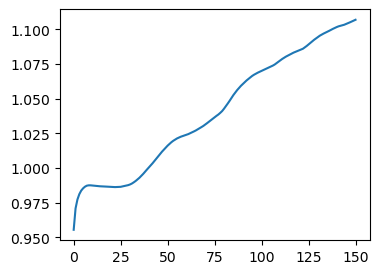

In [7]:
# plot snr_100 average intensity over time
plt.figure(figsize=(4,3))
plt.plot(np.mean(data_snr100, axis=(1,2,3)))

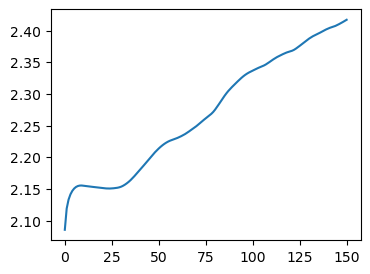

In [39]:
# plot ip average intensity over time
plt.figure(figsize=(4,3))
plt.plot(np.mean(ip['nn_interp'], axis=(1,2,3)))

**Remarks:**
- I'm looking for maxima in each slice along the z-axis, as this is the way I am computing maxima in the original dataset (tyx data).
- I need to detrend the data because the average fluorescence increases along time.

In [8]:
# detrend data_snr100 along time axis
from scipy import signal
data_snr100_detrended = signal.detrend(data_snr100, axis=0, type='linear')

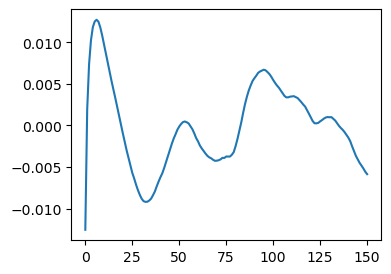

In [9]:
# plot detrended data_snr100 average intensity over time
plt.figure(figsize=(4,3))
plt.plot(np.mean(data_snr100_detrended, axis=(1,2,3)))

In [18]:
# visualize detrended data using napari
viewer = napari.Viewer()
viewer.add_image(data_snr100,
                 name='data snr100')
viewer.add_image(data_snr100_detrended,
                 name='data snr100 detrended')

<Image layer 'data snr100 detrended' at 0x1afc7ad3b80>

In [11]:
from scipy.ndimage import gaussian_filter, grey_dilation
from skimage.filters import threshold_otsu

def nonmaxima_suppression_tzyx(
        vol, neighborhood_radius=5, sigma=1.0, percentile=90
        ):
    '''
    vol is a 4D array of shape (t, z, y, x)
    '''
    # smooth data_
    smooth = gaussian_filter(vol, sigma=(sigma, 0 , sigma, sigma))

    # compute smoot data's otus threshold
    otsu_t = threshold_otsu(smooth)

    # compute percentile of smooth data where otsu threshold is exceeded
    percentile_smooth = np.percentile(smooth[smooth > otsu_t], percentile)

    # threshold smooth data wrt 90th percentile
    thresholded_smooth = smooth > percentile_smooth

    # dilate smooth data
    dilated_smooth = grey_dilation(
        smooth, (neighborhood_radius, 0, neighborhood_radius, neighborhood_radius)
        )

    # get mask where smooth data is equal to dilated smooth data and
    # smooth data is above threshold
    argmaxima = np.logical_and(
        smooth == dilated_smooth,
        thresholded_smooth
        )
    
    # compute maxima's coordinates
    argwhere = np.argwhere(argmaxima)


    return argwhere, argmaxima, thresholded_smooth

In [12]:
# find local maxima in data_snr100
argwhere, argmaxima, thresholded_smooth = nonmaxima_suppression_tzyx(
    vol=data_snr100,
    neighborhood_radius=5,
    sigma=0.5,
    percentile=99
    ) 

# find local maxima in detrended data_snr100
argwhere_detrended, argmaxima_detrended, thresholded_smooth_detrended = nonmaxima_suppression_tzyx(
    vol=data_snr100_detrended,
    neighborhood_radius=5,
    sigma=0.5,
    percentile=99
    )

In [13]:
argmaxima.shape

(151, 22, 80, 54)

In [14]:
len(argwhere)

314

In [15]:
# visualize local maxima with napari
viewer = napari.Viewer()
viewer.add_image(data_snr100,
                 name='data snr100')

viewer.add_labels(argmaxima, 
                  name='local maxima', 
                  opacity=0.5, 
                  #visible=False
                  )

viewer.add_labels(argmaxima_detrended,
                    name='local maxima detrended',
                    opacity=0.5,
                    #visible=False
                    )

viewer.add_labels(thresholded_smooth,
                    name='thresholded smooth',
                    opacity=0.5,
                    #visible=False
                    )

<Labels layer 'thresholded smooth' at 0x1afd8144940>

#### Interpolate video to match original dataset's sampling time

This is done via the method `video_spline_interpolation` of the `SparkDataset` class

### Run UNet on simulated data

#### Load UNet model